In [10]:
import sys
import os
import importlib
import gc
import glob
import random
from itertools import combinations

import numpy as np
import sklearn
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

import mdtraj as md
import pyemma

import extq
import ivac

In [11]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting

In [3]:
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
cm_seq = sns.cubehelix_palette(
    start=0, rot=-0.70, gamma=0.40, light=0.9, dark=0.1, as_cmap=True, reverse=True
)
cm_seq2 = sns.cubehelix_palette(
    start=0, rot=-0.70, gamma=0.40, light=0.8, dark=0.1, as_cmap=True, reverse=False
)
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("", colors)

# Load data

In [4]:
cv_trajs = list(
    np.load("../../data/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(
    np.load("../../data/raw_feat/cv_dist_spin_suppl_00.npy", allow_pickle=True)
)
cv_trajs.extend(
    np.load("../../data/raw_feat/cv_dist_spin_suppl_01.npy", allow_pickle=True)
)
cv_trajs.extend(
    np.load("../../data/raw_feat/cv_dist_spin_suppl_02.npy", allow_pickle=True)
)

In [5]:
sb_labels = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_labels.append(f"{r} - {n}")

In [6]:
sb_trajs = list(np.load("../../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
for i in range(6):
    sb_trajs.extend(
        np.load(f"../../data/raw_feat/feat2_suppl_{i:02d}.npy", allow_pickle=True)
    )

In [7]:
cv_arr = np.concatenate(cv_trajs)
sb_arr = np.concatenate(sb_trajs)
print(cv_arr.shape, sb_arr.shape)

(3729000, 2) (3729000, 60)


In [8]:
traj_files = np.loadtxt("../../data/suppl_traj_files.txt", dtype=str)

In [9]:
len(traj_files)

244

## Compute argnine rotamers

In [10]:
# all sidechain torsions for arginines
arg_tors = pyemma.coordinates.featurizer("../../civsd-pro.pdb")
for r in (217, 223, 226, 229, 232):
    arg_tors.add_sidechain_torsions(f"residue {r}", deg=False, which="all")
arg_tors.describe()

/project2/roux/scguo/anaconda/envs/py39/lib/python3.9/site-packages/pyemma/coordinates/data/featurization/angles.py:211: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  indices = np.vstack(valid.values())


['CHI1 0 ARG 217',
 'CHI2 0 ARG 217',
 'CHI3 0 ARG 217',
 'CHI4 0 ARG 217',
 'CHI5 0 ARG 217',
 'CHI1 0 ARG 223',
 'CHI2 0 ARG 223',
 'CHI3 0 ARG 223',
 'CHI4 0 ARG 223',
 'CHI5 0 ARG 223',
 'CHI1 0 ARG 226',
 'CHI2 0 ARG 226',
 'CHI3 0 ARG 226',
 'CHI4 0 ARG 226',
 'CHI5 0 ARG 226',
 'CHI1 0 ARG 229',
 'CHI2 0 ARG 229',
 'CHI3 0 ARG 229',
 'CHI4 0 ARG 229',
 'CHI5 0 ARG 229',
 'CHI1 0 ARG 232',
 'CHI2 0 ARG 232',
 'CHI3 0 ARG 232',
 'CHI4 0 ARG 232',
 'CHI5 0 ARG 232']

In [11]:
xtc_files = np.loadtxt("../../data/suppl_xtc_files.txt", dtype=str)
print(xtc_files)

['/project2/roux/scguo/ci-vsd/unbiased/083/civsd_pro.xtc'
 '/project2/roux/scguo/ci-vsd/unbiased/084/civsd_pro.xtc'
 '/project2/roux/scguo/ci-vsd/unbiased/085/civsd_pro.xtc'
 '/project2/roux/scguo/ci-vsd/unbiased/086/civsd_pro.xtc'
 '/project2/roux/scguo/ci-vsd/unbiased/087/civsd_pro.xtc'
 '/project2/roux/scguo/ci-vsd/unbiased/088/civsd_pro.xtc'
 '/project2/roux/scguo/ci-vsd/unbiased/089/civsd_pro.xtc'
 '/project2/roux/scguo/ci-vsd/unbiased/090/civsd_pro.xtc'
 '/project2/roux/scguo/ci-vsd/unbiased/091/civsd_pro.xtc'
 '/project2/roux/scguo/ci-vsd/unbiased/092/civsd_pro.xtc'
 '/project2/roux/scguo/ci-vsd/unbiased/093/civsd_pro.xtc'
 '/project2/roux/scguo/ci-vsd/unbiased/094/civsd_pro.xtc'
 '/project2/roux/scguo/ci-vsd/unbiased/095/civsd_pro.xtc'
 '/project2/roux/scguo/ci-vsd/unbiased/096/civsd_pro.xtc'
 '/project2/roux/scguo/ci-vsd/unbiased/097/civsd_pro.xtc'
 '/project2/roux/scguo/ci-vsd/unbiased/098/civsd_pro.xtc'
 '/project2/roux/scguo/ci-vsd/unbiased/099/civsd_pro.xtc'
 '/project2/ro

In [12]:
arg_tors_suppl = pyemma.coordinates.load(
    list(xtc_files), features=arg_tors, chunksize=24
)

07-01-22 13:52:05 pyemma.coordinates.data.feature_reader.FeatureReader[0] WARNING  duplicate files/arrays detected


100%|██████████| 30375/30375 [02:58<00:00, 169.95it/s]                                 


In [12]:
# top = md.load("../../civsd-pro.pdb").topology

In [13]:
# inds = []
# for i in (217, 223, 226, 229, 232):
#     arg_i = []
#     top.select(f"residue {i} and sidechain and (name CA CB CD CZ ND)")

In [14]:
arg_tors_trajs = list(
    np.load("../../data/raw_feat/arg_torsions.npy", allow_pickle=True)
)

In [16]:
np.save("../../data/raw_feat/arg_torsions_suppl.npy", arg_tors_suppl)

In [17]:
arg_tors_trajs.extend(arg_tors_suppl)

In [18]:
print(len(arg_tors_trajs), arg_tors_trajs[-1].shape)

480 (3000, 25)


In [19]:
arg_tors_models = np.load("../../data/models_centroids_arg_torsions.npy")

# Plot committors

In [20]:
qp_du = np.load("../../data/feat2_dist_du_suppl_2/q_downup.npy", allow_pickle=True)
qm_du = np.load("../../data/feat2_dist_du_suppl_2/qb_downup.npy", allow_pickle=True)
qp_ud = np.load("../../data/feat2_dist_du_suppl_2/q_updown.npy", allow_pickle=True)
qp_ud = np.load("../../data/feat2_dist_du_suppl_2/qb_updown.npy", allow_pickle=True)

In [21]:
lags = [1, 2, 5, 10, 20, 50]

In [22]:
random.seed(123)

In [23]:
s = 10
N = len(cv_arr)
inds = random.sample(range(N), N // s)

In [24]:
arg_tors_arr = np.concatenate(arg_tors_trajs) * 180 / np.pi

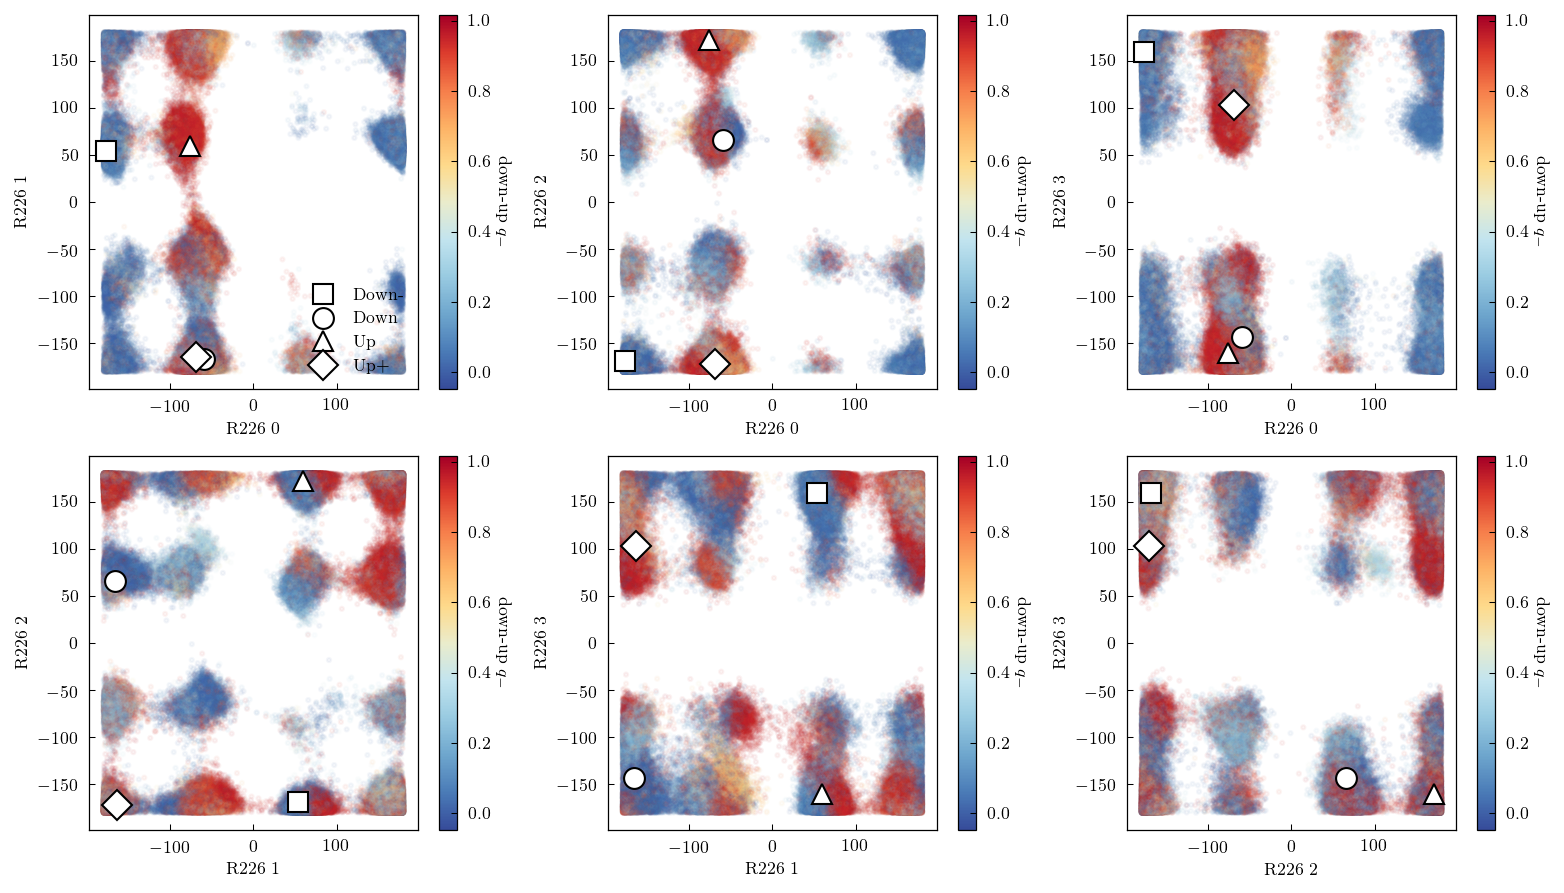

In [33]:
# for D->U transition, the R226 is the one moving through the plug
f, axs = plt.subplots(2, 3, figsize=(10.5, 6))

q_arr = np.concatenate(qp_du[-1])
for ax, (chi_i, chi_j) in zip(axs.flat, combinations((10, 11, 12, 13), 2)):
    h = ax.scatter(
        arg_tors_arr[inds, chi_i],
        arg_tors_arr[inds, chi_j],
        c=q_arr[inds],
        cmap=cm_div,
        alpha=0.05,
    )
    ax.set(xlabel=f"R226 $\chi_{chi_i - 10}$", ylabel=f"R226 $\chi_{chi_j - 10}$")
    plotting.plot_models(ax, arg_tors_models[:, [chi_i, chi_j]] * 180 / np.pi)
    cbar = plt.colorbar(h, ax=ax)
    cbar.solids.set(alpha=1)
    cbar.set_label("down-up $q_-$", rotation=-90, labelpad=10)

axs.flat[0].legend(["Down-", "Down", "Up", "Up+"], loc="lower right")
f.tight_layout()

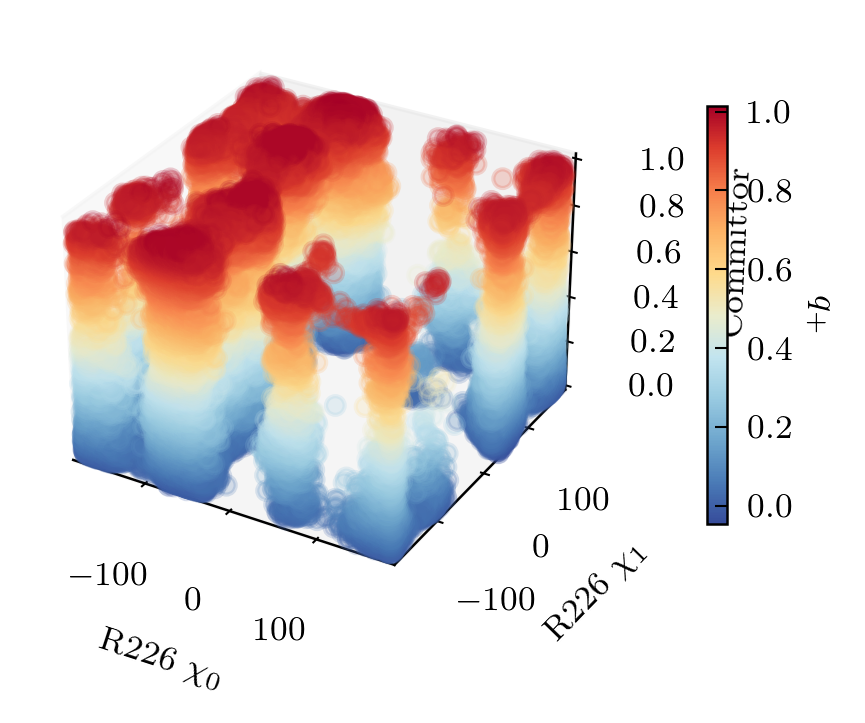

In [34]:
f = plt.figure(dpi=300)
ax = f.add_subplot(projection="3d")

h = ax.scatter(
    arg_tors_arr[inds, 10],
    arg_tors_arr[inds, 11],
    q_arr[inds],
    c=q_arr[inds],
    cmap=cm_div,
    alpha=0.2,
)
ax.set_xlabel("R226 $\chi_0$")
ax.set_ylabel("R226 $\chi_1$")
ax.set_zlabel("Committor")
ax.set_xlim([-180, 180])
ax.set_ylim([-180, 180])
ax.set_zlim([0, 1.0])
cbar = plt.colorbar(h, ax=ax, pad=0.15, fraction=0.03, label="$q_+$")
cbar.solids.set(alpha=1)
cbar.set_label("$q_+$", rotation=-90, labelpad=10)

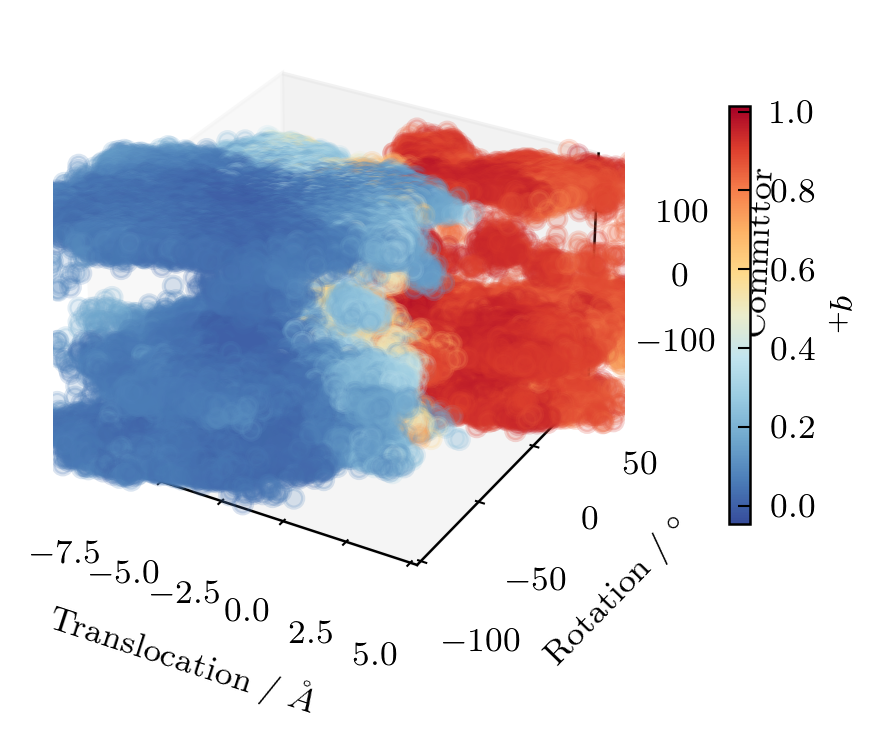

In [36]:
f = plt.figure(dpi=300)
ax = f.add_subplot(projection="3d")

h = ax.scatter(
    cv_arr[inds, 0],
    cv_arr[inds, 1],
    arg_tors_arr[inds, 10],
    c=q_arr[inds],
    cmap=cm_div,
    alpha=0.2,
)
ax.set_xlabel("Translocation / $\AA$")
ax.set_ylabel("Rotation / $^\circ$")
ax.set_zlabel("Committor")
ax.set_xlim([-7.5, 5])
ax.set_ylim([-100, 50])
ax.set_zlim([-180, 180])
cbar = plt.colorbar(h, ax=ax, pad=0.15, fraction=0.03)
cbar.solids.set(alpha=1)
cbar.set_label("$q_+$", rotation=-90, labelpad=10)

In [70]:
# extract points which are between 0.45 and 0.55 committor
q = np.concatenate(qp_du[-1])
q_ts_inds = ((q < 0.55) & (q > 0.45)).nonzero()[0]
q_ts = q[q_ts_inds]

In [71]:
arg_tors_ts = arg_tors_arr[q_ts_inds]

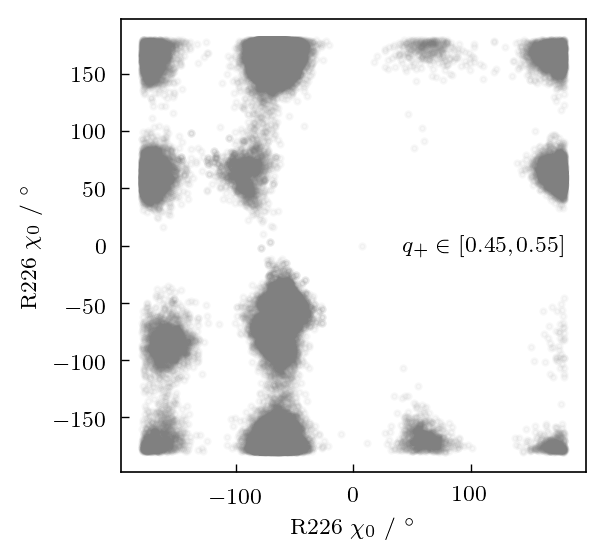

In [72]:
f = plt.figure(dpi=200)
ax = plt.gca()
h = ax.scatter(arg_tors_ts[..., 10], arg_tors_ts[..., 11], alpha=0.05, color="grey")
ax.set_xlabel("R226 $\chi_0$ / $^\circ$")
ax.set_ylabel(f"R226 $\chi_0$ / $^\circ$")
ax.legend(["$q_+ \in [0.45, 0.55]$ "])

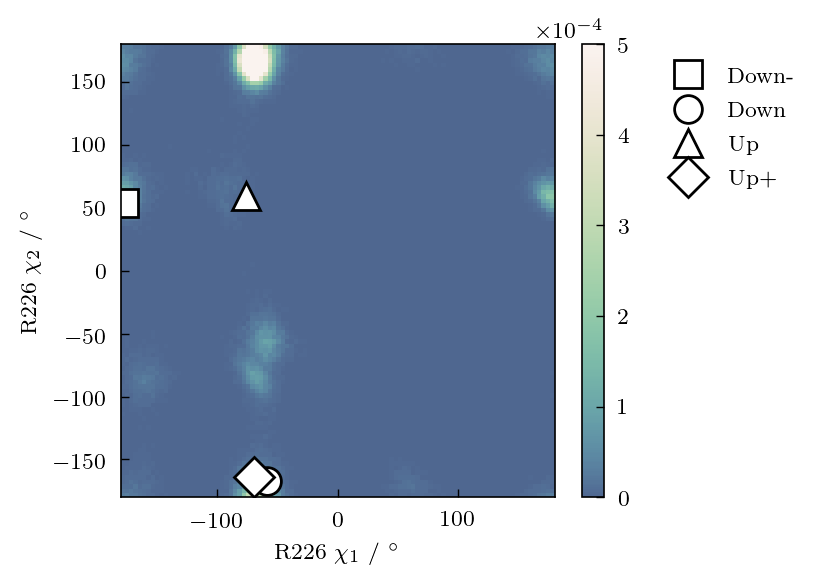

In [89]:
f = plt.figure(figsize=(3.5, 3), dpi=200)
ax = plt.gca()
hist, xe, ye = np.histogram2d(
    arg_tors_ts[..., 10], arg_tors_ts[..., 11], bins=100, density=True
)
h = ax.pcolor(xe, ye, hist.T, cmap=cm_seq, vmax=5e-4)
ax.set_xlabel("R226 $\chi_1$ / $^\circ$")
ax.set_ylabel(f"R226 $\chi_2$ / $^\circ$")
plotting.plot_models(ax, arg_tors_models[:, [10, 11]] * 180 / np.pi)
plt.legend(["Down-", "Down", "Up", "Up+"], bbox_to_anchor=(1.6, 1))
plt.colorbar(h, ax=ax)

In [95]:
np.unravel_index(np.argmax(hist), hist.shape)  # (-72, 166)

(30, 96)

In [99]:
close_ids = util.find_closest_points((-72, 166), arg_tors_ts[:, [10, 11]], n=20)
for i in q_ts_inds[close_ids]:
    #     print(sb_arr[i, [42, 27]])
    if i < 3000000:
        print(util.anton_frame(i))
    else:
        x = i - 3000000
        print(f"{xtc_files[x // 3000]}, {x % 3000}")

(182, 26151)
(181, 12041)
(181, 13364)
(264, 5259)
/project2/roux/scguo/ci-vsd/unbiased/146/civsd_pro.xtc, 2388
(22, 3716)
/project2/roux/scguo/ci-vsd/unbiased/146/civsd_pro.xtc, 510
(264, 3845)
(126, 8001)
/project2/roux/scguo/ci-vsd/unbiased/288/civsd_pro_1.xtc, 956
(181, 8990)
(10, 8990)
(181, 13079)
/project2/roux/scguo/ci-vsd/unbiased/270/civsd_pro.xtc, 2453
(281, 6712)
(244, 4370)
(281, 6148)
(230, 1071)
(195, 3901)
(125, 8645)


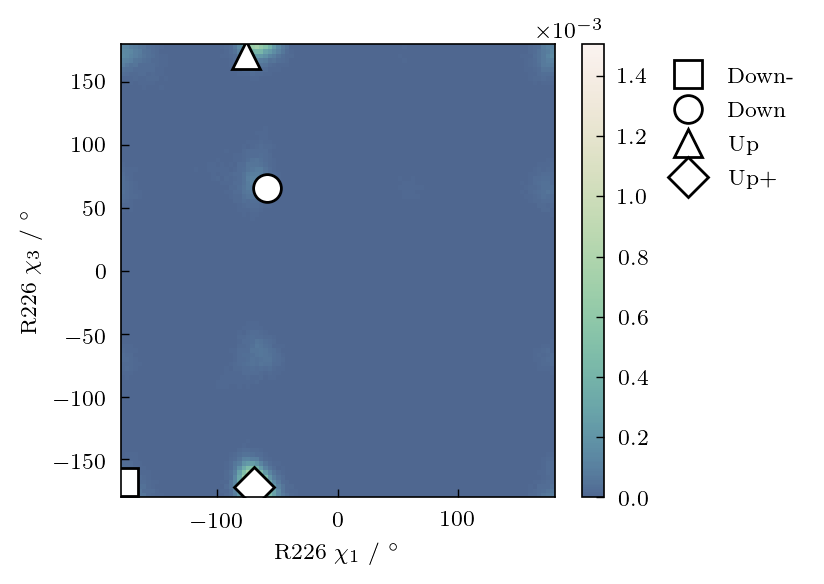

In [84]:
f = plt.figure(figsize=(3.5, 3), dpi=200)
ax = plt.gca()
hist, xe, ye = np.histogram2d(
    arg_tors_ts[..., 10], arg_tors_ts[..., 12], bins=100, density=True
)
h = ax.pcolor(xe, ye, hist.T, cmap=cm_seq)
ax.set_xlabel("R226 $\chi_1$ / $^\circ$")
ax.set_ylabel(f"R226 $\chi_3$ / $^\circ$")
plotting.plot_models(ax, arg_tors_models[:, [10, 12]] * 180 / np.pi)
plt.legend(["Down-", "Down", "Up", "Up+"], bbox_to_anchor=(1.6, 1))
plt.colorbar(h, ax=ax)

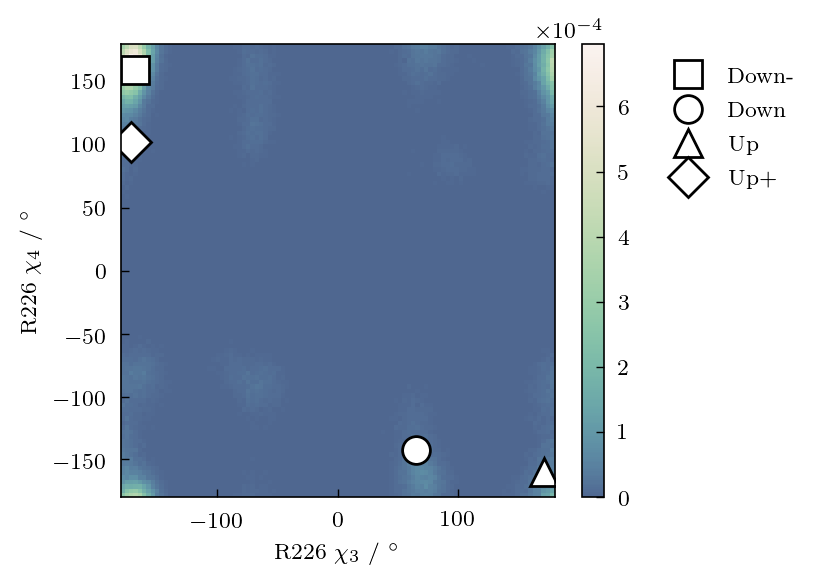

In [101]:
f = plt.figure(figsize=(3.5, 3), dpi=200)
ax = plt.gca()
hist, xe, ye = np.histogram2d(
    arg_tors_ts[..., 12], arg_tors_ts[..., 13], bins=100, density=True
)
h = ax.pcolor(xe, ye, hist.T, cmap=cm_seq)
ax.set_xlabel("R226 $\chi_3$ / $^\circ$")
ax.set_ylabel(f"R226 $\chi_4$ / $^\circ$")
plotting.plot_models(ax, arg_tors_models[:, [12, 13]] * 180 / np.pi)
plt.legend(["Down-", "Down", "Up", "Up+"], bbox_to_anchor=(1.6, 1))
plt.colorbar(h, ax=ax)

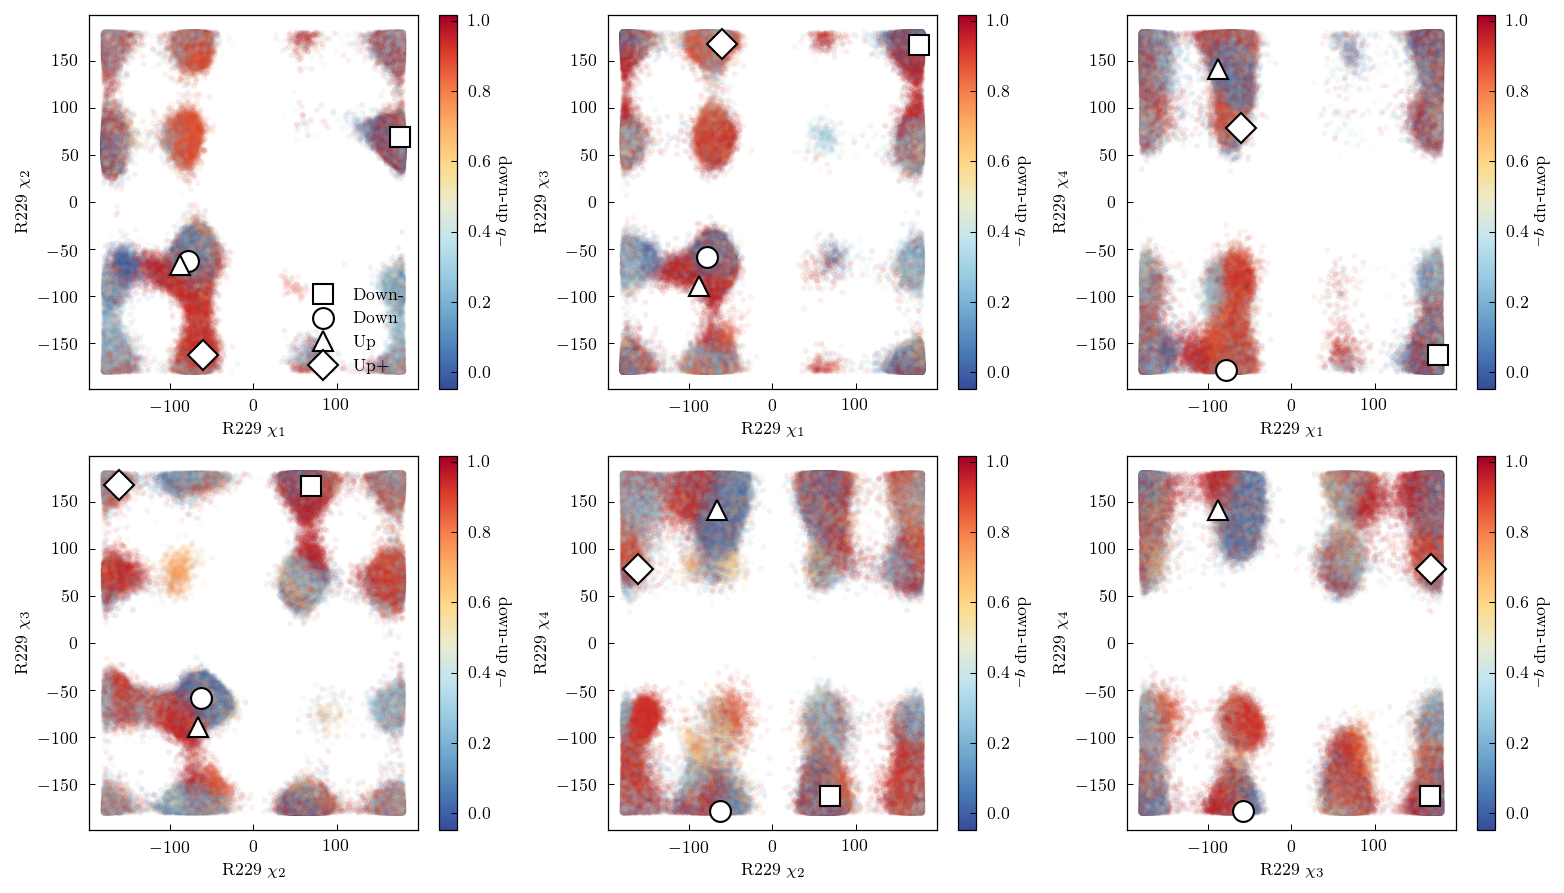

In [85]:
# what about R229?
f, axs = plt.subplots(2, 3, figsize=(10.5, 6))

q_arr = np.concatenate(qp_du[-1])
for ax, (chi_i, chi_j) in zip(axs.flat, combinations((15, 16, 17, 18), 2)):
    h = ax.scatter(
        arg_tors_arr[inds, chi_i],
        arg_tors_arr[inds, chi_j],
        c=q_arr[inds],
        cmap=cm_div,
        alpha=0.05,
    )
    ax.set(xlabel=f"R229 $\chi_{chi_i - 14}$", ylabel=f"R229 $\chi_{chi_j - 14}$")
    plotting.plot_models(ax, arg_tors_models[:, [chi_i, chi_j]] * 180 / np.pi)
    cbar = plt.colorbar(h, ax=ax)
    cbar.solids.set(alpha=1)
    cbar.set_label("down-up $q_-$", rotation=-90, labelpad=10)

axs.flat[0].legend(["Down-", "Down", "Up", "Up+"], loc="lower right")
f.tight_layout()

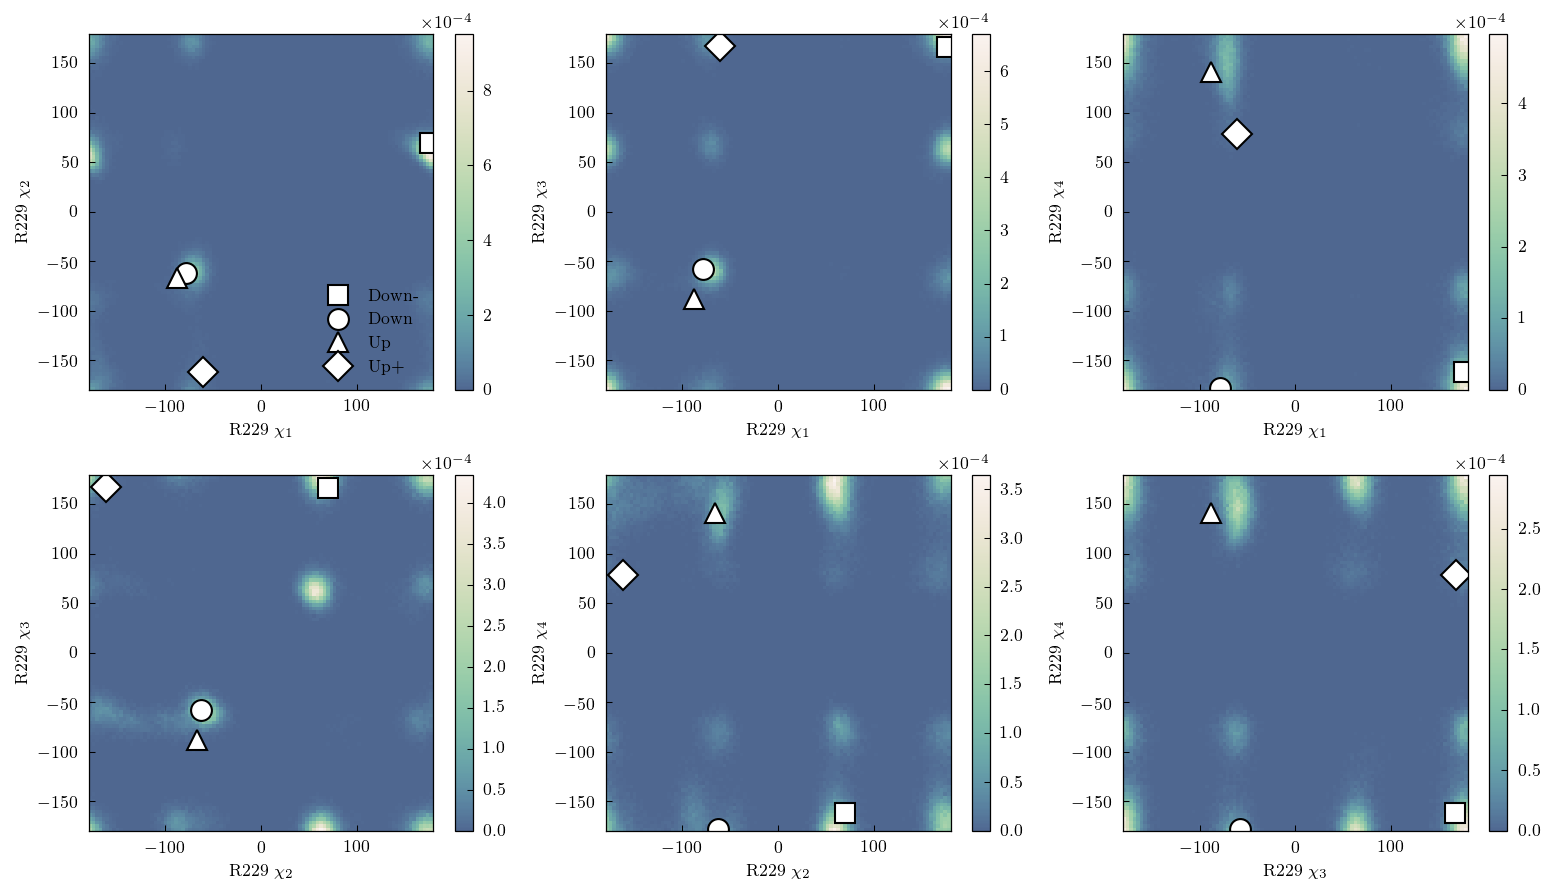

In [86]:
# what about R229?
f, axs = plt.subplots(2, 3, figsize=(10.5, 6))

q_arr = np.concatenate(qp_du[-1])
for ax, (chi_i, chi_j) in zip(axs.flat, combinations((15, 16, 17, 18), 2)):
    hist, xe, ye = np.histogram2d(
        arg_tors_ts[..., chi_i], arg_tors_ts[..., chi_j], bins=100, density=True
    )
    h = ax.pcolor(xe, ye, hist.T, cmap=cm_seq)

    ax.set(xlabel=f"R229 $\chi_{chi_i - 14}$", ylabel=f"R229 $\chi_{chi_j - 14}$")
    plotting.plot_models(ax, arg_tors_models[:, [chi_i, chi_j]] * 180 / np.pi)
    cbar = plt.colorbar(h, ax=ax)
    cbar.solids.set(alpha=1)

axs.flat[0].legend(["Down-", "Down", "Up", "Up+"], loc="lower right")
f.tight_layout()

# Perform PCA on 5 backbone $\chi$ angles of R226

In [74]:
arg_tors_trajs[0][0, 0]

-1.5272981

In [81]:
r226_chi = np.concatenate(arg_tors_trajs)[:, 10:15]
r226_chi_sc = np.hstack((np.sin(r226_chi), np.cos(r226_chi)))
pca = pyemma.coordinates.pca(data=r226_chi_sc, dim=10)

In [82]:
r226_pc = pca.fit_transform(r226_chi_sc)

In [83]:
r226_pc.shape

(3729000, 10)

In [86]:
arg_tors_models_sc = np.hstack(
    (np.sin(arg_tors_models[:, 10:15]), np.cos(arg_tors_models[:, 10:15]))
)
models_pc = pca.transform(arg_tors_models_sc)

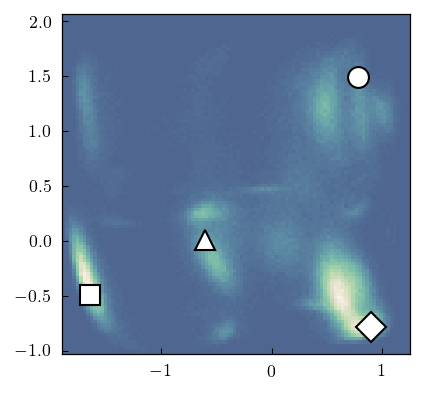

In [87]:
hist, xe, ye, h = plt.hist2d(
    r226_pc[inds, 0], r226_pc[inds, 1], bins=100, density=True, cmap=cm_seq
)
ax = plt.gca()
plotting.plot_models(ax, models_pc[:, :2])

In [88]:
pca_raw = pyemma.coordinates.pca(data=r226_chi, dim=5)

In [89]:
r226_pc_raw = pca_raw.fit_transform(r226_chi)

In [90]:
models_pc_raw = pca_raw.transform(arg_tors_models[:, 10:15])

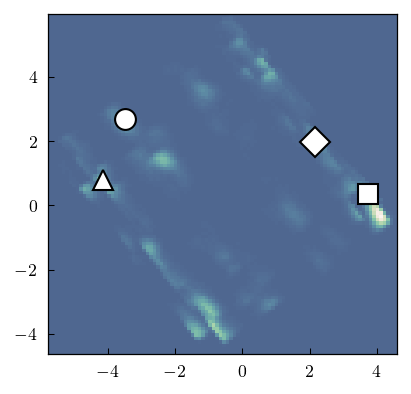

In [91]:
hist, xe, ye, h = plt.hist2d(
    r226_pc_raw[inds, 0], r226_pc_raw[inds, 1], bins=100, density=True, cmap=cm_seq
)
ax = plt.gca()
plotting.plot_models(ax, models_pc_raw[:, [0, 1]])

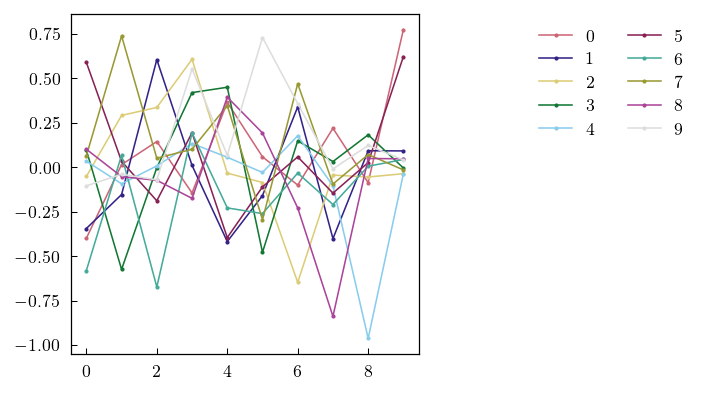

In [92]:
for i, ev in enumerate(pca.eigenvectors):
    plt.plot(ev, ".-", label=i)
plt.legend(bbox_to_anchor=(1.3, 1), ncol=2)

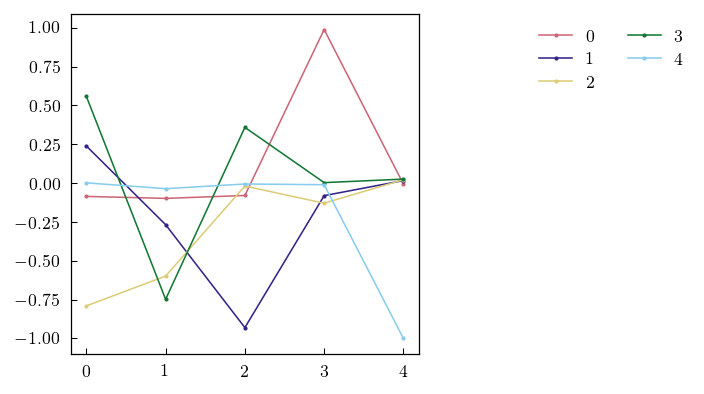

In [93]:
for i, ev in enumerate(pca_raw.eigenvectors):
    plt.plot(ev, ".-", label=i)
plt.legend(bbox_to_anchor=(1.3, 1), ncol=2)

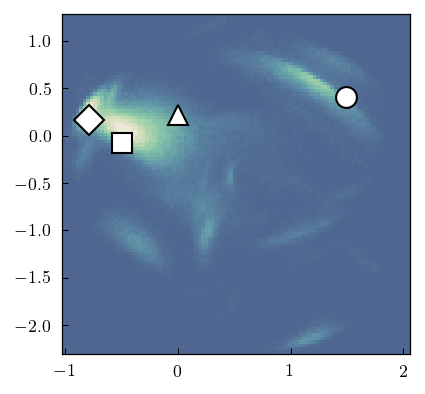

In [94]:
hist, xe, ye, h = plt.hist2d(
    r226_pc[inds, 1], r226_pc[inds, 3], bins=100, density=True, cmap=cm_seq
)
ax = plt.gca()
plotting.plot_models(ax, models_pc[:, [1, 3]])

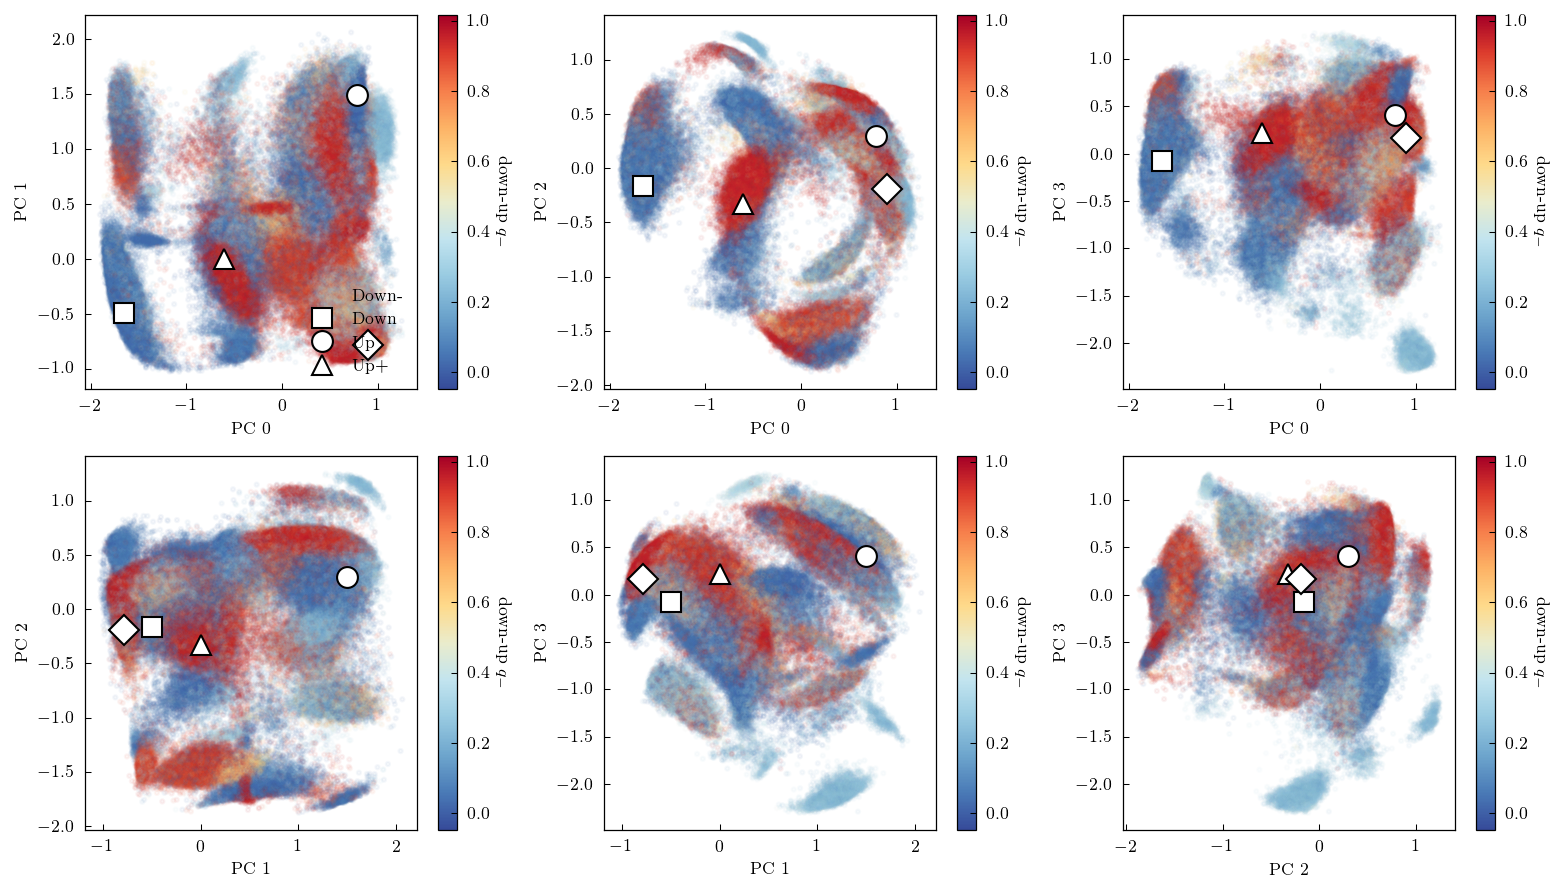

In [95]:
# plot committors against principal components
f, axs = plt.subplots(2, 3, figsize=(10.5, 6))

q_arr = np.concatenate(qp_du[-1])
for ax, (i, j) in zip(axs.flat, combinations(range(0, 4), 2)):
    h = ax.scatter(
        r226_pc[inds, i], r226_pc[inds, j], c=q_arr[inds], cmap=cm_div, alpha=0.05
    )
    ax.set(xlabel=f"PC {i}", ylabel=f"PC {j}")
    plotting.plot_models(ax, models_pc[:, [i, j]])
    cbar = plt.colorbar(h, ax=ax)
    cbar.solids.set(alpha=1)
    cbar.set_label("down-up $q_-$", rotation=-90, labelpad=10)

axs.flat[0].legend(["Down-", "Down", "Up", "Up+"], loc="lower right")
f.tight_layout()

# IVAC with all sidechain dihedrals

In [101]:
livac = ivac.LinearIVAC(minlag=0, maxlag=10000, addones=True, adjust=True)
livac.fit(arg_tors_trajs)
arg_tors_ivac_trajs = livac.transform(arg_tors_trajs)

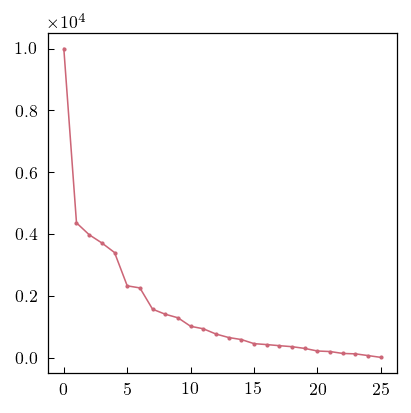

In [102]:
plt.plot(livac.evals, ".-")

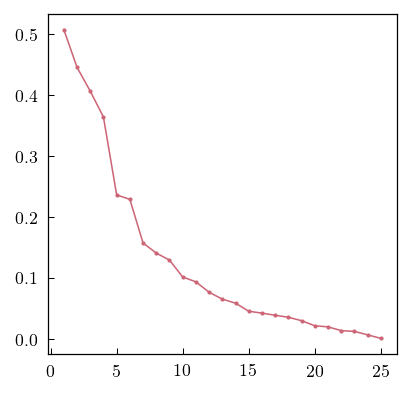

In [103]:
plt.plot(livac.its * 0.0001, ".-")

In [108]:
ivac_models = livac.transform([arg_tors_models])[0]

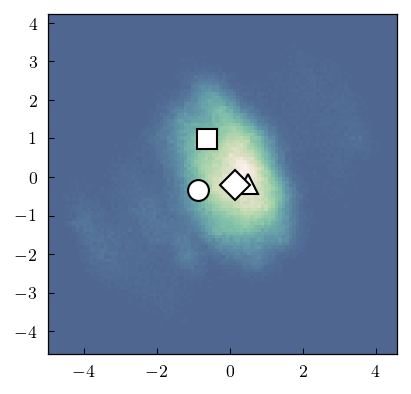

In [110]:
arg_tors_ivac_arr = np.concatenate(arg_tors_ivac_trajs)
hist, xe, ye, h = plt.hist2d(
    arg_tors_ivac_arr[inds, 1],
    arg_tors_ivac_arr[inds, 2],
    bins=100,
    density=True,
    cmap=cm_seq,
)
ax = plt.gca()
plotting.plot_models(ax, ivac_models[:, [1, 2]])

In [111]:
livac = ivac.LinearIVAC(minlag=0, maxlag=10000, addones=False, adjust=True)
livac.fit(arg_tors_trajs)
arg_tors_ivac_trajs = livac.transform(arg_tors_trajs)

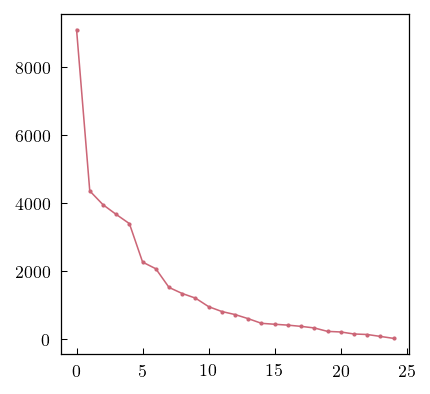

In [112]:
plt.plot(livac.evals, ".-")

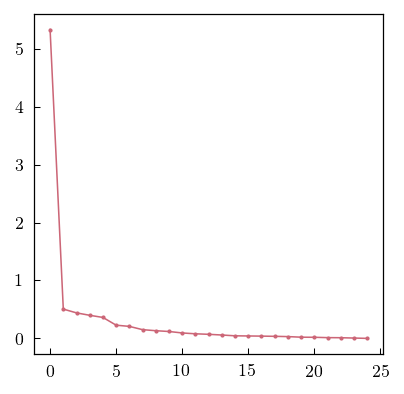

In [113]:
plt.plot(livac.its * 0.0001, ".-")

In [114]:
ivac_models = livac.transform([arg_tors_models])[0]

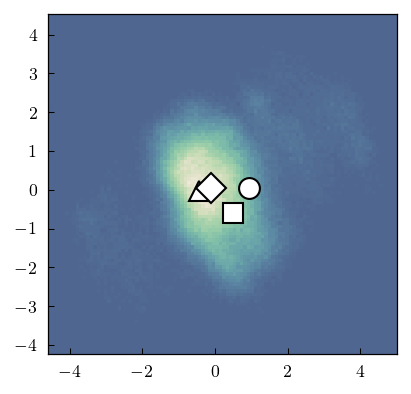

In [115]:
arg_tors_ivac_arr = np.concatenate(arg_tors_ivac_trajs)
hist, xe, ye, h = plt.hist2d(
    arg_tors_ivac_arr[inds, 1],
    arg_tors_ivac_arr[inds, 2],
    bins=100,
    density=True,
    cmap=cm_seq,
)
ax = plt.gca()
plotting.plot_models(ax, ivac_models[:, [1, 2]])